<a href="https://colab.research.google.com/github/koluzaeva/advance-ML-MADE-2023/blob/main/hw/advaneced_ML_MADE_2023_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

###1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [2]:
data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [ ]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [3]:
data_rus = data[(data.location == 'Russia') & (data.date >= '2020-03-03')].drop_duplicates(subset='date').reset_index(drop=True).dropna(axis=0, subset=['total_cases'])

In [4]:
def x_replace(x):
  if x == 0:
    return 1.0
  return x

data_rus.new_cases = list(map(x_replace, data_rus.new_cases))

In [ ]:
data_rus.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
2,RUS,Europe,Russia,2020-03-05,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
3,RUS,Europe,Russia,2020-03-06,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
4,RUS,Europe,Russia,2020-03-07,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [5]:
y_total = list(data_rus.total_cases)
y_new = list(data_rus.new_cases)
X = list(data_rus.index)
X_train, y_total_train, y_new_train = X[:50], y_total[:50], y_new[:50]
X_test, y_total_test, y_new_test = X[50:], y_total[50:], y_new[50:]


###2.Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


Text(0.5, 1.0, 'Total cases')

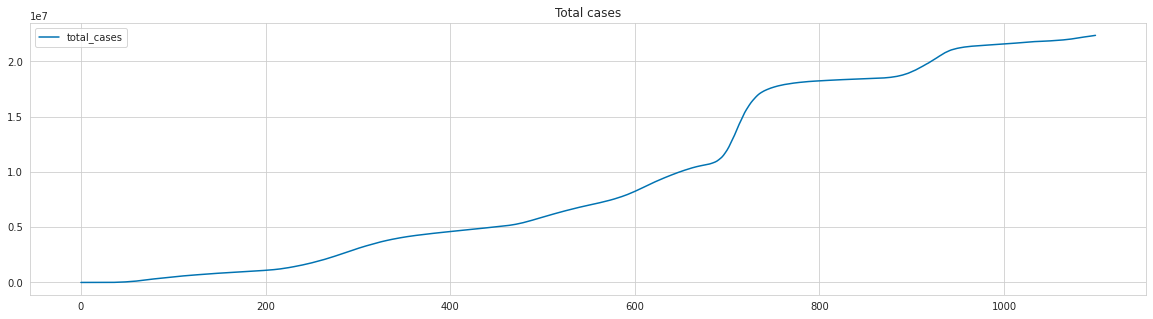

In [6]:
fig = plt.figure(figsize=(20,5))

sns.lineplot(data=data_rus[['total_cases']])
plt.title("Total cases")


Text(0.5, 1.0, 'New cases')

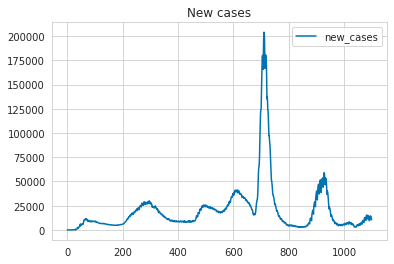

In [7]:
sns.lineplot(data=data_rus[['new_cases']])
plt.title("New cases")

####2a Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.


a = 1.1934192756385693
b = 0.2141063665825282


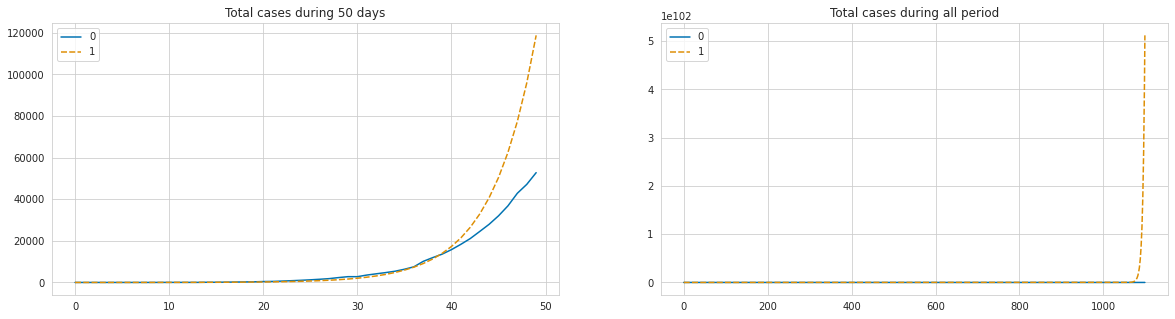

a = -0.40597701698373534
b = 0.19995828847940364


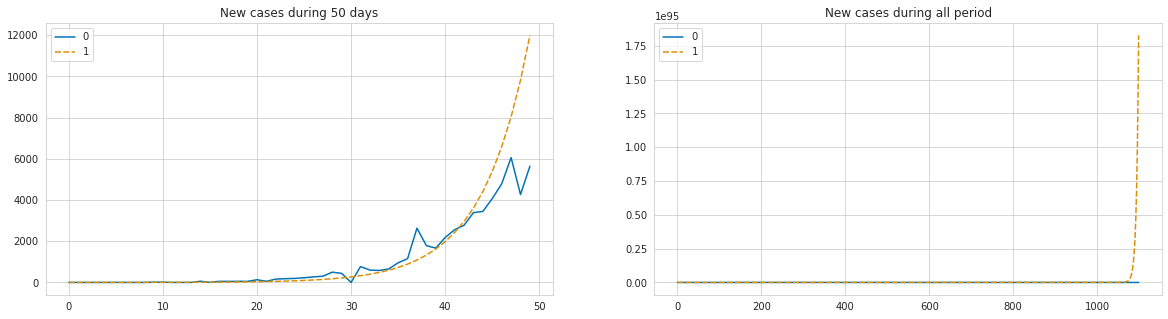

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

def fit_n_plot(x_all, y_all, name, test_index=50):

  # Преобразуем y в логарифм
  y_log = np.log(y_all)

  # Создаем и обучаем модель
  model = LinearRegression()
  model.fit(np.array(x_all[:test_index]).reshape(-1, 1), y_log[:test_index])

  # Выводим коэффициенты модели
  print('a =', model.intercept_)
  print('b =', model.coef_[0])

  fig = plt.figure(figsize=(20,5))

  y_pred = model.predict(np.array(x_all).reshape(-1, 1))
  plt.subplot(1, 2, 1, title=f'{name} cases during 50 days')
  sns.lineplot(data=[y_all[:test_index], np.exp(y_pred)[:test_index]])
  plt.subplot(1, 2, 2, title=f'{name} cases during all period')
  sns.lineplot(data=[y_all, np.exp(y_pred)])
  plt.show()

fit_n_plot(X, y_total, 'Total')
fit_n_plot(X, y_new, 'New')

2b Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


2c Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


Построим априорное распределение для $\mu = (0, 0), σ= [[200, 0], [0, 200]]$

In [ ]:
def myplot_sample_lines(mu, sigma, x, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    for w in my_w:
        #print(w, np.exp(w[0] + w[1]*xs))
        plt.plot(np.linspace(0, x.shape[0], x.shape[0]), np.exp(x.dot(w)), 'k-', lw=.4)
    plt.ylim((0, 6 * 10**4))
    plt.xlim((0, 60))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

In [ ]:
def bayesian_update(mu, sigma, x, y, sigma_noise=None):
  
    if not sigma_noise:
      sigma_noise = np.std(y - x.dot(np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)))
    
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.dot(x.T, x))
    mu_n = np.dot(sigma_n, np.dot(np.linalg.inv(sigma), mu) + (1 / (sigma_noise ** 2)) * np.dot(x.T, y))
    return mu_n, sigma_n


Mu: [1.19339048 0.21410724], sigma: [[ 4.85282332e-03 -1.47055251e-04]
 [-1.47055251e-04  6.00229265e-06]] for Total cases
Mu: [-0.40596702  0.19995798], sigma: [[ 4.85282332e-03 -1.47055251e-04]
 [-1.47055251e-04  6.00229265e-06]] for New cases


Text(0.5, 1.0, 'New cases')

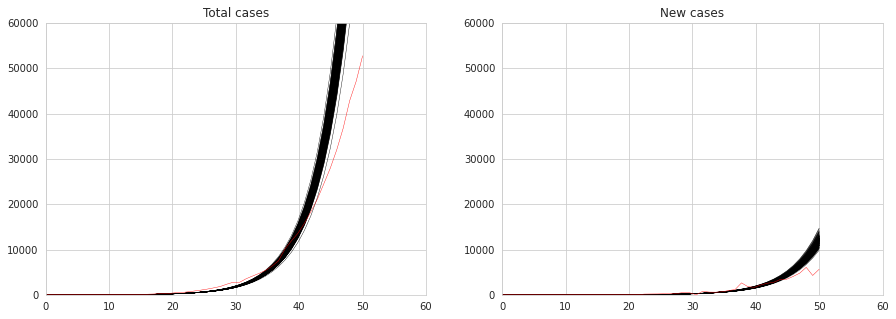

In [ ]:
y_total = np.array(data_rus.total_cases)
y_new = np.array(data_rus.new_cases)
X = np.array(data_rus.index)
X = np.insert(X.reshape(-1, 1), 0, 1, axis=1)
X_train, y_total_train, y_new_train = X[:50], y_total[:50], y_new[:50]
X_test, y_total_test, y_new_test = X[50:], y_total[50:], y_new[50:]


cur_mu, cur_sigma = np.array([0, 0]), 200*np.array([[1, 0], [0, 1]])
cur_mu_total, cur_sigma_total = bayesian_update(cur_mu, cur_sigma, X_train, np.log(y_total_train), sigma_noise=.25)

print(f'Mu: {cur_mu_total}, sigma: {cur_sigma_total} for Total cases')
figsize=(15, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(121)

myplot_sample_lines(cur_mu_total, cur_sigma_total, X_train, 200)
plt.plot(np.linspace(0, X_train.shape[0], X_train.shape[0]), y_total_train, 'r-', lw=.4)
plt.title('Total cases')

cur_mu_new, cur_sigma_new = bayesian_update(cur_mu, cur_sigma, X_train, np.log(y_new_train), sigma_noise=.25)
print(f'Mu: {cur_mu_new}, sigma: {cur_sigma_new} for New cases')

ax = fig.add_subplot(122)

myplot_sample_lines(cur_mu_new, cur_sigma_new, X_train, 200)
plt.plot(np.linspace(0, X_train.shape[0], X_train.shape[0]), y_new_train, 'r-', lw=.4)
plt.title('New cases')

In [ ]:
# Посэмплируем экспоненты и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, x, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, x.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(x.dot(w))
    return res

In [ ]:
# Нарисуем результат
def plot_predictions(X, Y, mu, x_stat, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 100))
    ax.set_ylim((0, 10**6))
    
    ax.plot(np.linspace(0, X.shape[0], X.shape[0]), list(Y), label="Правильный ответ")
    ax.plot(np.linspace(0, X.shape[0], X.shape[0]), list(np.exp(X.dot(mu))), color="red", label="MAP гипотеза")
    #ax.fill_between(np.linspace(0, X.shape[0], X.shape[0]), np.exp(X.dot(mu)) - noise, np.exp(X.dot(mu)) + noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(np.linspace(0, X.shape[0], X.shape[0]), np.mean(x_stat, axis=0) - np.std(x_stat, axis=0), np.mean(x_stat, axis=0) + np.std(x_stat, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], color='r', marker='*', s=200)
    ax.legend(fontsize=16)

 Спрогнозируем число случаев коронавируса в России к 1 мая, к 1 июня, к 1 сентября. И построим предсказательные распределения по данным сэмплирования

 Найдем номер дня для соответствующих дат в таблице data_rus 



Дата 2020-05-01, число всех случаев (прогноз): 1007793, реальность: 114431.0
Дата 2020-05-01, число новых случаев (прогноз): 88891, реальность: 7933.0
Дата 2020-06-01, число всех случаев (прогноз): 796514652, реальность: 414878.0
Дата 2020-06-01, число новых случаев (прогноз): 43175633, реальность: 9035.0
Дата 2020-09-01, число всех случаев (прогноз): 278674651933603744, реальность: 1000048.0
Дата 2020-09-01, число новых случаев (прогноз): 4987763413441423, реальность: 4729.0


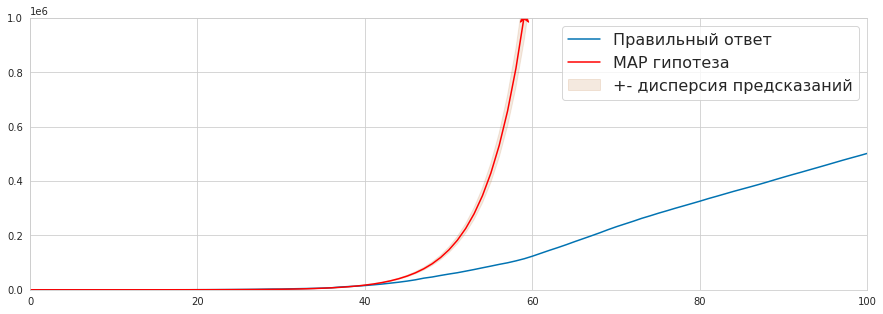

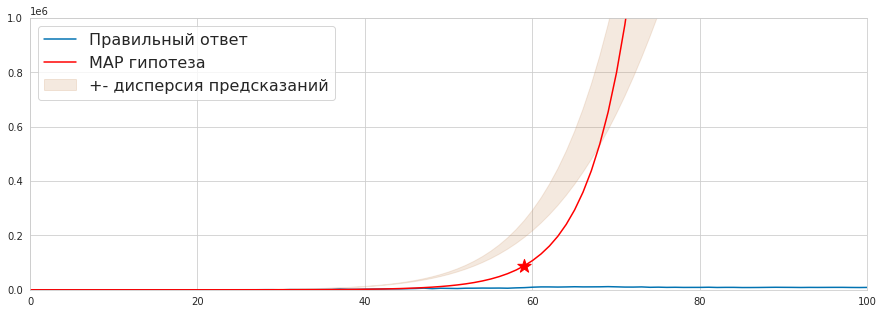

In [ ]:
idx = []
date_pred_total = []
date_pred_new = []

for d in ['2020-05-01', '2020-06-01', '2020-09-01']:
  idx.append(data_rus[data_rus.date == d].index[0])
  w_total = np.random.multivariate_normal(cur_mu_total, cur_sigma_total, 100)
  date_pred_total.append(np.mean(list(map(lambda w: np.exp(w[0] + w[1] * idx[-1]), w_total))))
  print(f'Дата {d}, число всех случаев (прогноз): {round(date_pred_total[-1])}, реальность: {y_total[idx[-1]]}')

  w_new = np.random.multivariate_normal(cur_mu_new, cur_sigma_new, 100)
  date_pred_new.append(np.mean(list(map(lambda w: np.exp(w[0] + w[1] * idx[-1]), w_new))))
  print(f'Дата {d}, число новых случаев (прогноз): {round(date_pred_new[-1])}, реальность: {y_new[idx[-1]]}')


x_total = sample_statistics(cur_mu_total, cur_sigma_total, np.array(X), n=1000)
plot_predictions(X, y_total, cur_mu_total, x_total, [idx, date_pred_total])

x_new = sample_statistics(cur_mu_new, cur_sigma_new, np.array(X), n=1000)
plot_predictions(X, y_new, cur_mu_new, x, [idx, date_pred_new])


Построим плотность распределения предсказанных значений числа заболевших по данным сэмплирования для 1 мая, 1 июня, 1 сентября.

Сначала для всех случаев

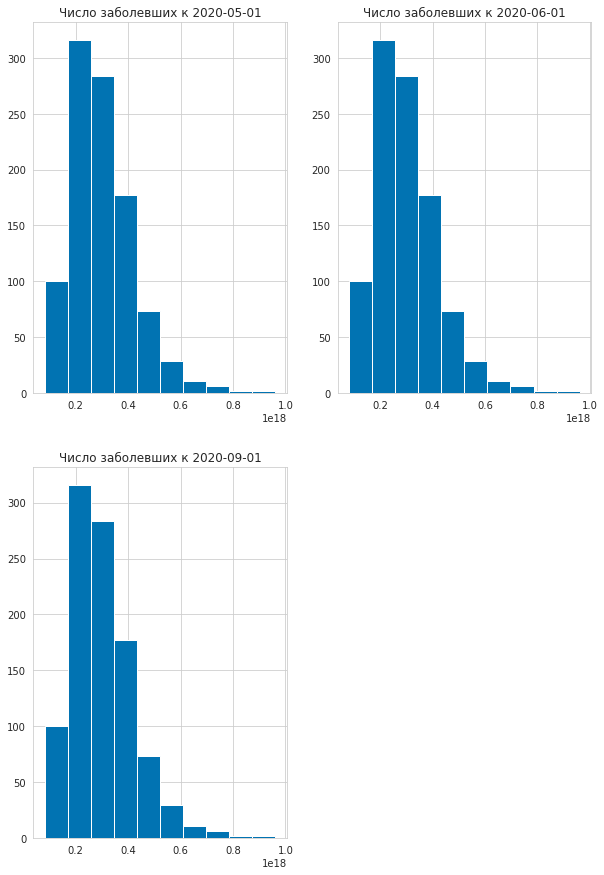

In [ ]:
fig = plt.figure(figsize=(10, 15))

for i, date in enumerate(['2020-05-01', '2020-06-01', '2020-09-01']):
  idx = data_rus[data_rus.date == d].index[0]
  plt.subplot(2, 2, i + 1)
  plt.hist(x_total[:, idx])
  plt.title(f'Число заболевших к {date}')

Теперь для новых случаев

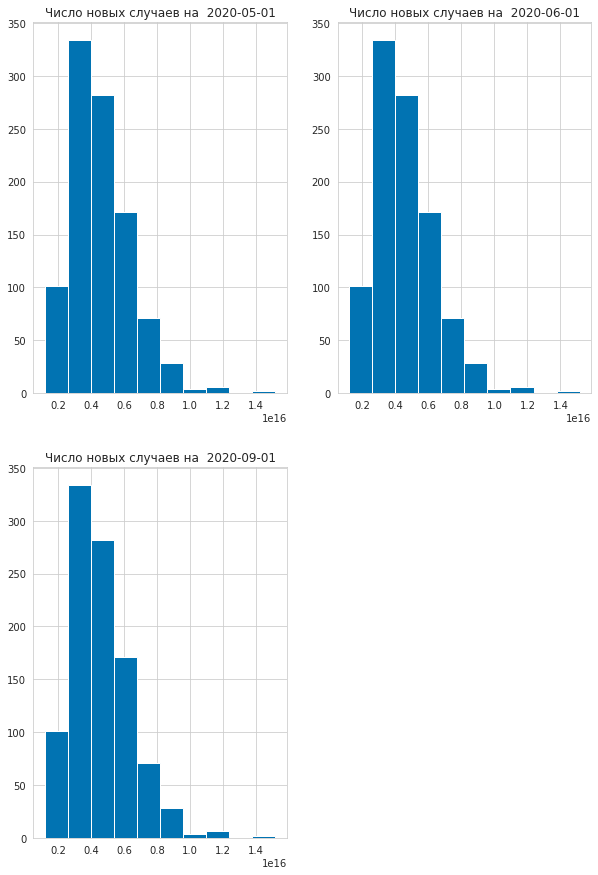

In [ ]:
fig = plt.figure(figsize=(10, 15))

for i, date in enumerate(['2020-05-01', '2020-06-01', '2020-09-01']):
  idx = data_rus[data_rus.date == d].index[0]
  plt.subplot(2, 2, i + 1)
  plt.hist(x_new[:, idx])
  plt.title(f'Число новых случаев на  {date}')

3 Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

a Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

b Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

c Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?



Для того, чтобы обучить сигмоидальную функцию (с интегралом)  с помощью линейной регрессии продифференцируем обе части по x:

  $y = \int_{-\inf}^x {exp(-\phi(w, t)) dt}$, где $\phi(w, t) = w_0 + w_1t +w_2 t^2$


-квадратичная функция от t.

После диффиринцирования получаем:

$∇ y = exp(-\phi(w, x)) = exp(w_0 + w_1x +w_2 x^2)$

Возьмем натуральный логорифм от обеих частей:

$\ln(Δ y) = w_0 + w_1x +w_2 x^2$

Производная

 $\nabla y = \lim_{Δ t → 0}\frac{y(t+Δ t) - y(t)}{Δt}$ ,
 
 для общего числа случаев заболевания при $Δt = 1$ получаем, что это количество новых заболеваний в сутки, т.е. 

 
 $\nabla y_{total\_cases} ≈ y_{new\_cases}$



In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np


# Преобразуем y в логарифм
X = np.array(data_rus.index).reshape(-1, 1)
X = np.hstack((X, X ** 2))
#X = np.insert(X.reshape(-1, 1), 0, 1, axis=1)
y_new = np.array(data_rus.new_cases)
X_train, y_new_train = X[:50], y_new[:50]
X_test, y_new_test = X[50:], y_new[50:]


# Создаем и обучаем модель
model_sigm = LinearRegression()
model_sigm.fit(X_train, np.log(y_new_train))

# Выводим коэффициенты модели
print('w0 =', model_sigm.intercept_)
print('w1, w2 =', model_sigm.coef_)


w0 = -0.8725577869316457
w1, w2 = [ 0.25828088 -0.00119026]


In [ ]:
def cdf_y(y_pred):
  return np.cumsum(np.exp(y_pred), axis=0)

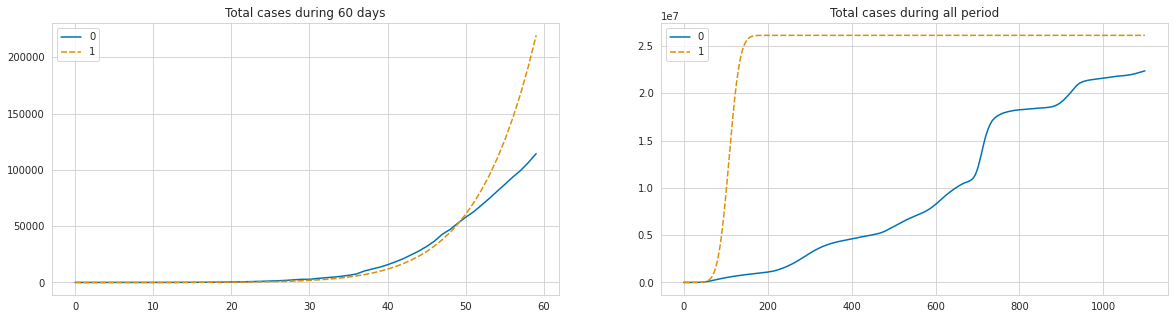

In [ ]:
fig = plt.figure(figsize=(20,5))

y_pred = model_sigm.predict(X)
y_total_pred = cdf_y(y_pred)
plt.subplot(1, 2, 1, title='Total cases during 60 days')
sns.lineplot(data=[y_total[:60], y_total_pred[:60]])
plt.subplot(1, 2, 2, title='Total cases during all period')
sns.lineplot(data=[y_total, y_total_pred])
plt.show()


In [ ]:
def myplot_sample_sigm(mu, sigma, x, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    for w in my_w:
        y_pred = w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,2]
       
        
        plt.plot(np.linspace(0, x.shape[0], x.shape[0]), cdf_y(y_pred), 'k-', lw=.4)
    plt.ylim((0, 6 * 10**4))
    plt.xlim((0, 60))
    if not points is None:
        plt.scatter(points[0], points[1], marker='-', s=200)

Mu: [-0.8725485   0.25828013 -0.00119024], sigma: [[ 1.03958188e-02 -8.39923317e-04  1.41401230e-05]
 [-8.39923317e-04  9.26108498e-05 -1.76752190e-06]
 [ 1.41401230e-05 -1.76752190e-06  3.60719181e-08]]


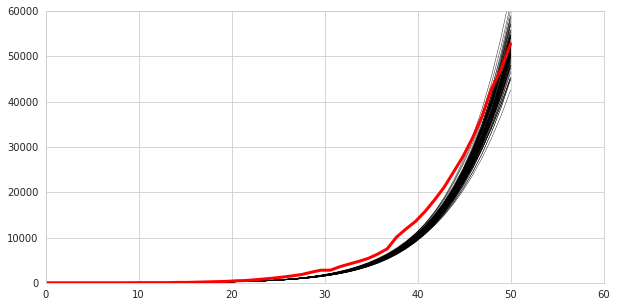

In [ ]:
X = np.array(data_rus.index).reshape(-1, 1)
X = np.hstack((X, X ** 2))
X = np.insert(X, 0, 1, axis=1)
y_new = np.array(data_rus.new_cases)
X_train, y_new_train = X[:50], y_new[:50]
X_test, y_new_test = X[50:], y_new[50:]

cur_mu, cur_sigma = np.array([0, 0, 0]), 1000*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X_train, np.log(y_new_train), sigma_noise=.25)

print(f'Mu: {cur_mu}, sigma: {cur_sigma}')
figsize=(10, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

myplot_sample_sigm(cur_mu, cur_sigma, X_train, 100)
plt.plot(np.linspace(0, X_train.shape[0], X_train.shape[0]), y_total_train, 'r-', lw=3)

In [ ]:
# Посэмплируем сигмоиды и выдадим статистики по предсказаниям
def sample_statistics_sigm(mu, sigma, x, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, x.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = cdf_y(x.dot(w))
    return res

In [ ]:
# Нарисуем результат
def plot_predictions_sigm(X, Y, mu, x_stat,x_lim=1000, y_lim=3*10**7):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((0, x_lim))
    ax.set_ylim((0, y_lim))
    ax.plot(np.linspace(0, X.shape[0], X.shape[0]), Y, label="Правильный ответ")
    ax.plot(np.linspace(0, X.shape[0], X.shape[0]), cdf_y(X.dot(mu)), color="red", label="MAP гипотеза")
    #ax.fill_between(np.linspace(0, X.shape[0], X.shape[0]), cdf_y(X.dot(mu)) - 0.25, cdf_y(X.dot(mu)) + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(np.linspace(0, X.shape[0], X.shape[0]), np.mean(x_stat, axis=0) - np.std(x_stat, axis=0), np.mean(x_stat, axis=0) + np.std(x_stat, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    #ax.scatter(points[0], points[1], color='r', marker='*', s=200)
    ax.legend(fontsize=16)

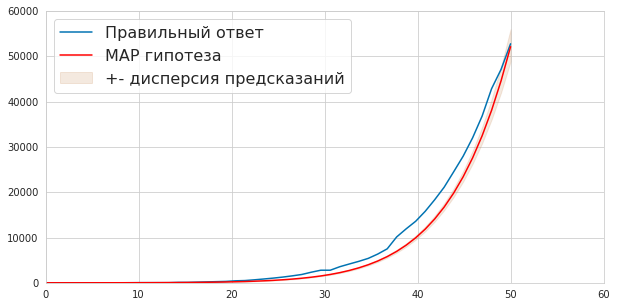

In [ ]:
x = sample_statistics_sigm(cur_mu, cur_sigma, X_train, n=1000)
plot_predictions_sigm(X_train, y_total_train, cur_mu, x, x_lim=60, y_lim=6*10**4)


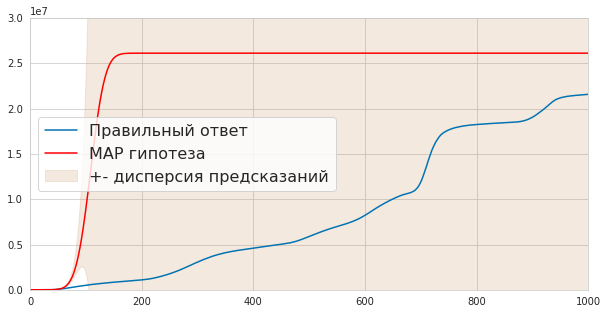

In [ ]:
x = sample_statistics_sigm(cur_mu, cur_sigma, X, n=1000)
plot_predictions_sigm(X, y_total, cur_mu, x)


3 c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [ ]:
max_cases = np.mean(x[:, -1])
opt_cases = np.quantile(x[:, -1], q=0.1)
pes_cases = np.quantile(x[:, -1], q=0.9)
print(f'Максимальное число случаев {max_cases:.4E}, в оптимистичном сценарии {opt_cases:.4E}, в пессимистичном - {pes_cases:.4E}')

Максимальное число случаев 2.8743E+08, в оптимистичном сценарии 6.5857E+06, в пессимистичном - 2.4049E+08


Видим, что среднее значение максимального числа заболевших превышает 90% процентиль. На графике плотности распределения вероятностей максимального общего числа заболевших видно, что значения этой СВ попадают в основном в один бин и имеется небольшой хвост, с большими значениями СВ,куда попадают около 10% значений.   

,num
count,1.000000e+03
mean,2.874297e+08
std,2.289919e+09
min,1.870112e+06
10%,6.585654e+06
25%,1.275405e+07
50%,2.922915e+07
90%,2.404885e+08
99%,3.371796e+09
max,5.089939e+10


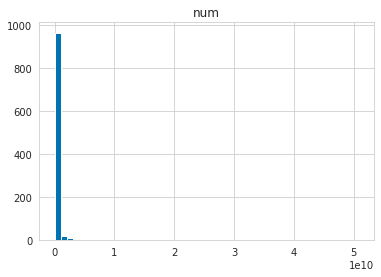

In [ ]:
x_max = pd.DataFrame(np.array(x[:, -1]).reshape(-1, 1), columns=['num'])
x_max.hist(bins=50)
x_max.describe(percentiles=[0.1, 0.25, 0.5, 0.9, 0.99])

4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

5. [Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


###Выводы.
В первые 50 дней активного роста заболевания общее число случаем заболеваемости имело экспаненциальный рост, однако число новых случаев заболеваний не иммет постоянной тенденции роста. Рост заболеваемости связан с сезонностью вирусных заболеваний, появлением новых штамов вируса. С другой стороны, снижение заболеваемости наблюдается в периоды не связанные с вирусной активностью, и после начала массовой вакцинации. Таким образом, если число новых случаев не растет постоянно, общее число заболевших так же не будет подчиняться экспоненциальному росту. Из графика видно, что общее число заболеваний изменяется скорее ступенчато: в определенные периоды набирая эспоненциальный рост (вспышки заболевания), а потом выходя на плато. Поэтому ни одна из исследуемых моделей не может достаточно точно апроксимировать датасет.

Из всего вышесказанного, я могу сделать следующие выводы:

1) данные по короновирусу не являются достоверными, в связи со многими факторами: недостаток тестов, персонала, бессимптомное протекание болезни в некоторых случаях, целенаправленное занижение данных статистики.

2) в случае пандемии долгосрочный прогноз является затруднительным.

3) число новых случаев заболевания зависит не только от номера дня, но и от множества других факторов, которые не отражены в датасете.

4) в эпидемиологии используются собственные вероятностные модели SIR, SEIR. 